## Predicting the Winner of a Reality Show
If you have ever watched a elimination reality show, they can be addicting. Who will be eliminated next? Who are the top three? Who will win this season? It can be hard to tell, because it's entirely based on the judge's decision. But sometimes viewers can be spot on about whether contestants will be eliminated or not. This begs the question, are judges influence by the audience's reaction?

Usually the audience views a recorded version of the events. The data that we can obtain to predict our winner is solely based on how the audience reacts to each contestant on the show. After an episode ends, we can assume the audience's curiosity is peaked and they search for contestants online.

To predict the winner of Season 9 for our reality show, we obtain our data about the popularity of former contestants from Google Trends. Google Trends is reliable because it provides historical data where we can evaluate past trends. From Google Trends, we pull normalized daily values of Google Searches on each contestant. We will also find the trends of these data points and take the trend's coefficients of the first and second degree polynomials as features in our training set.

## Obtaining Data from Google Trends
In order to gather data from each contestant, we need a list of their names. Their names will be used as google search queries inputted into the Google Trends API to search for historical data.

Once the list of names is obtained, we want to use interest_over_time(iot) from the Google Trends API. This function gets a normalized value of how many times a contestant was searched on Google during the airing of their season. Since the iot from the API accepts one interval of time, the function get_iot takes in a splice of names and time period and returns the interest over time for contestants in a given season.

Since the seasons are not the same length, we must address this problem as missing data. To solve this, we are grabbing time periods of 180 days before the last airing day of the season. This allows the seasons to be the same length. We assume the data grabbed before the season doesn't have high values (not a lot of Google searches before the season) and will help the during season data begin to have an upward trend.

In [ ]:
def get_iot(List, time_period):
    '''get_iot takes in a splice and a time period and returns volume searches for each splice, max splice intervals is 5
        Accepts: List        - list of contestant's names (queries)
                 time_period - string, dates when show airs to last airing
        Returns: pre_iot     - array of volume search for each contestant in each splice before the season
                 iot         - array of volume search for each contestnat in each splice inseason 
    '''
    
    trend.build_payload(kw_list = List, timeframe = time_period)
    iot = trend.interest_over_time()
    return iot

#### Normalizing the Data

Google Trends interest_over_time data is normalized, but the function will only accept a list of five queries. Therefore, data extracted within a list of five queries is normalized, but is not normalized between lists. To minimize this bias, we grab one contestant from each season and find their max iot (M). Then we use get_iot to compare between the chosen contestant and each contestant in the season. We then find the chosen contestant's max with respect to each contestant (M_i). Then each contestant's iot is scaled by multiplying it by M/M_i. The normalize function is in a helper file.

#### Correlation in the Data

Now that the data is obtained in a dataframe, analyzing the data can provide more insight. For example, we can ask, is a column of data for one contestant correlated? We can find this correlation by fitting first and second degree trendlines to the data. These trendlines can show us a positive or negative correlation and whether our fitted quadratic is concave up or down. Are most of the contestant's Google searches toward the beginning of the season or the end? The below function helps us get the coefficients of the polynomials for our trendlines.

In [ ]:
def get_coeffs(col, deg):
    '''Get's coefficients of the polynomials of our trendlines
        Accepts: col - array of one contestant's column of 180 values.
                 deg - the deg of the polynomial that we want to fit with our data.
        Returns: z   - tuple of floats, tuple of 2 if deg is 1, tuple of 3 if deg is 2.
    '''
    x = np.linspace(0, col.shape[0] - 1, col.shape[0])
    z = np.polyfit(x = x, y = col, deg = deg)
    p = np.poly1d(z)
    return z

## Elimination Based Ranking

We could have a binary classification on our results and fiind out who won and who lost. However, if we want to know how well each contestant performed, we need to create an elimination based ranking. Here we separate contestants into seasons to rank how well they did in their season. 

This does include extra seasons called All Stars, which has contestants from previous seasons. This implies we have duplicate contestant names, but we will make an assumption that this will not affect our end result. Our purpose is to look at data within a season and seeing which features determine our winner. To simplify, features in one season won't affect the outcome in a different season.

We want to quantify the end result by an elimination ranking. This will tell us how well a contestant did in the season. Elimination based ranking goes as follows: Rank 4 will be assigned to contestants eliminated in the first half of their season, Rank 3 will be assigned to half of the remaining contestants, Rank 2 are runners up, and Rank 1 is the winner.

In [ ]:
def get_rank(seasons):
    '''assigns rank to each contestant based on when they were eliminated.
        Accepts: seasons - list of seasons, the split into seasons allows us to assign rank faster
        Returns: rankings - list of ints between 1-4
    '''
    rankings = []
    for season in seasons:
        bottom_half = len(season)/2
        for i in range(len(season)):
            if season[i] == season[-1]:
                rankings.append(1)
            elif i < bottom_half:
                rankings.append(4)
            elif season[i] not in season[-3:]:
                rankings.append(3)
            else:
                rankings.append(2)
    return rankings
rankings = np.array(get_rank(seasons))

## Data Visualization

Now that we have our data obtained, what does it tell us? Is there an obvious trend that one person is winning based on the volume of Google Searches for their name during the airing of the season? 

In [1]:
import helper_file as f
import pandas as pd
%matplotlib inline

data = pd.read_csv(filepath_or_buffer = '~/Documents/Volume3/vol3b/Web_Scrapping_Project/Contestants_Data_X.csv')
Data = data.T
target = pd.read_csv(filepath_or_buffer = '~/Documents/Volume3/vol3b/Web_Scrapping_Project/Contestants_Data_Y.csv')
data_S9 = pd.read_csv(filepath_or_buffer = '~/Documents/Volume3/vol3b/Web_Scrapping_Project/Contestants_Data_S9.csv')

Here we use Season 7 as an example to show what a "Daily Values", "Linear Trend", and "Quadratic Trend" plot would look like. Immediately below we have the Daily Values plot. Notice that the plot is noisy and we can't tell, even with the legend, what trend lines are apparent.

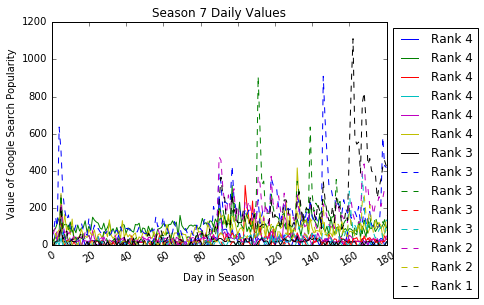

In [2]:
f.plot(Data, range(75, 89), 'daily values', 'Season 7')

To get a trend for each contestant, we use numpy's polyfit function. In our example, of Season 7 below, our Rank 1 winner (dotted black line) started off with low search volumes before the season. The linear trend lines help us clearly see as time progressed that the winner received more popularity even above other contestants.

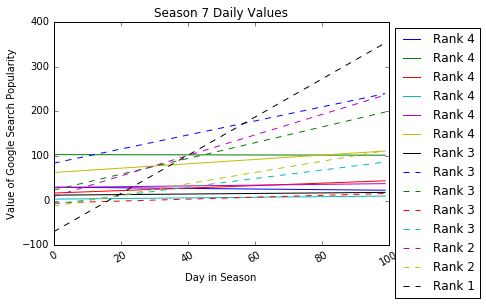

In [3]:
f.plot(Data, range(75, 89), 'linear trend', 'Season 7')

A Quadratic Trendline helps us see a more fitted trend to our data. Did one of our contestants reach max popularity in the middle of the season? Did any of our contestants dip in popularity but were able to gain it back? As we see below in Season 7, our Rank 1 winner, averaged about the middle and dipped a little low in the Pre-Season. Here we can infer, the audience had interest when the contestants were announced. Then the audience lost some interest before the season, but the had more interest in other contestants as potential winners based solely on their appearance. Finally, the winner at about Day 102, skyrocketed in popularity for the rest of the season. If this is what all of the winner's trend lines look like why would we even need a machine learning algorithm?

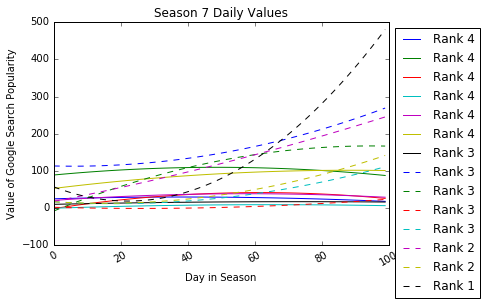

In [4]:
f.plot(Data, range(75, 89), 'quadratic trend', 'Season 7')

Notice below the Season 8 winner does not have an outstanding trend line like the winner of season 7 where we expect them to have a steeper slope. We even see a contestant in a solid magenta color doing better in Google Search popularity than the winner.

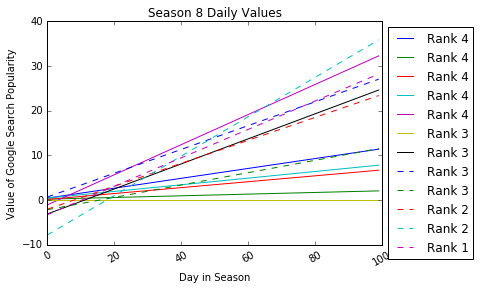

In [5]:
f.plot(Data, range(89, 101), 'linear trend', 'Season 8')

Similarly, we have a contestant below in the solid red doing better than the winner of the season of All Stars 2. If we look at the Daily Values plot of this Season, we can see that there are two peaks from the solid red line, and with a little more digging we find out that this contestant at the first peak voluntarily dropped out of the race, which probably earned them sympathy and curiousity from the audience. At the second peak, this contestant released an album, which earned them more popularity in Google Searches. So it's enough of an argument to exclude this outlier from the data, especially since their popularity came during the airing of the season but irrespective of the show.

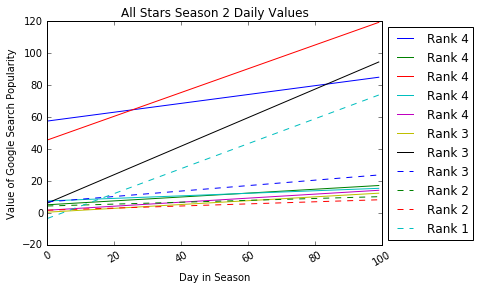

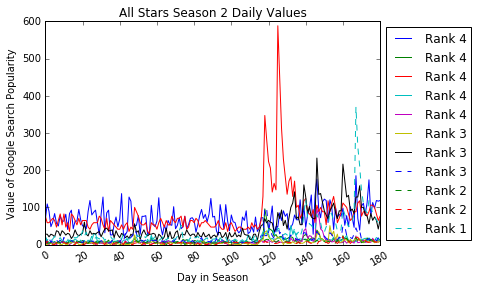

In [6]:
f.plot(Data, range(112, 123), 'linear trend', 'All Stars Season 2')
f.plot(Data, range(112, 123), 'daily values', 'All Stars Season 2')

The trend lines over the whole season and pre-season show us an overall trend, but even without outliers, it's hard to tell who the winner is even if we took the legend away. Instead of looking for trends for the winner, what if we looked at trends to see who will be eliminated next?

Let's look at season 7 to see if the next person eliminated has a trend in a given week. Also since we don't care about contestants that are eliminated previously, then they are not included in subsequent plots. Below, as we look week to week, contestants in solid blue (dotted blue after week 8) usually have a down trend, a low y-intercept, or both. We are showing weeks 1, 12, 13, and 14 for brevity.

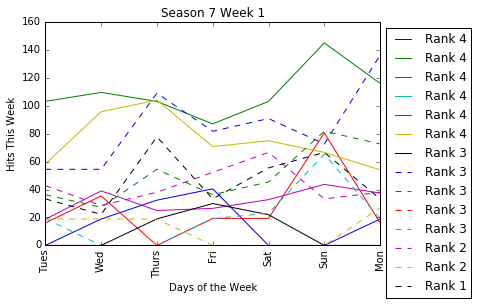

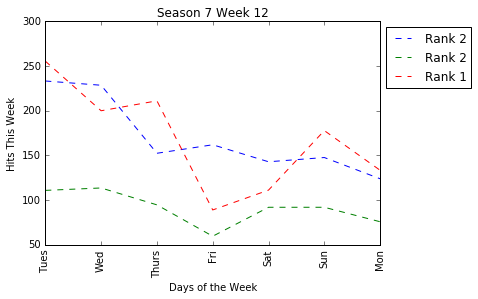

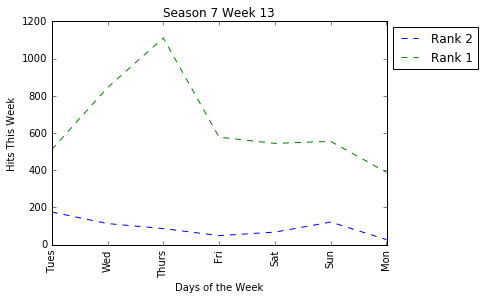

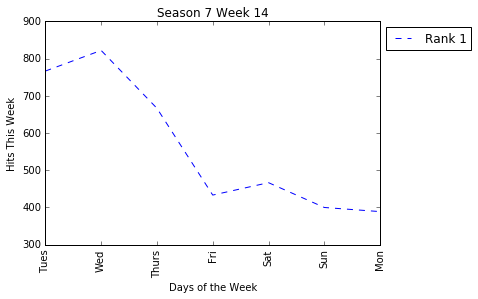

In [2]:
f.elimination_plot_seq(75, 89, 'Season 7', show = [1, 12, 13, 14])

## Our Data with the Random Forest Classifier

Since the Y of our dataset gives a list of rankings from 1 to 4, we need a machine learning algorithm that classifies each contestant with one of these four rankings. This estimator fits a number of decision tree classifiers on several sub-samples of our dataset. It uses averaging to improve the predictive accuracy and control over-fitting.

In [3]:
f.run_RFC(data, target)

The Best Score:				0.581395348837
Time is takes to fit and predict RFC	0.0920000076294


Some of the advantages of Random Forest are that it runs fast and it gives estimates of what variables are important in the classification, although it tends to overfit with noisy classification or regression tasks and this algorithm is greedy. As you can see above, Random Forest gives us the best accuracy for this data set at 58%.

#### Other Machine Learning Algorithms

Other Machine Learning Algorithms I've used are the XGBoost Classifier, Multiclass Logistic Regression, Support Vector Classification, and Quadratic Discriminant Analysis. I picked these five algorithms because I needed to do a multiclassification that can handle continuous data with zeros in it. 

XGBoost uses a more regularized model formalization to control over-fitting, which gives it better performance. The algorithm lives up to how fast it is, and compared to Random Forests, it is said to be more accurate, but the accuracy ranges around 52%.

Multinomial Logistic Regression is a classification method that generalizes logistic regression to problems with more than two possible discrete outcomes. Therefore, this algorithm assumes that there are linear decision boundaries which makes it intrinsically simple with low variance, and less prone to overfitting. However, the algorithm predicted our data with an accuracy of 54%.

The Support Vector Classification is inherently a two-class classifier. It can do multiclass problems using the "one against all" approach. It ultimately gave us 52% accuracy with the fastest time.

The Quadratic Discriminant Analysis sorts using quadratically fitted decision boundaries, which led to the hope of better accuracy. However, we only achieved an accuracy ranging from 24-35%.

I did venture to see how the data would work on a regression model, and I used the Decision Tree Regressor. I received a 20% accuracy, and then realized I need to change my catergorical target to a continuous target. Although the algorithm runs really fast, the accuracy never went abovee 40%.

#### Does this match my Proposal?

I didn't think that I would get any meaningful predictions from these algorithms, for a few reasons. First, the dataset I have chosen is small, and an algorithm like Random Forest runs effciently on large data sets. The features themselves in the data set are not inadequate, but if we had equally defining but more features, we would have a sufficient dataset. Also even though there are 185 features, 180 of them are daily values while the other two are grouped in linear and quadratic coefficients. If the features had more variance, we might have better accuracy.

However, with what I do have, if I tested this on the Season 9 data set, I would get close to a 60% accuracy  which is better than I expected. As I began to figured out which features I wanted, I started to feel like I needed a dataset of the whole season the day before the winner is announced to figure out who it is. However, in one of the algorithms, Random Forest Classifier, I can use max_features to limit the features to 110 or 150 and still get 58-60% accuracy. So if I decided to just use the daily values data and run it through the Random Forest Classifier with max_features 100, then I can know that 100 days before the season starts, I can guess an elimination ranking on all of the contestants of that season with 60% accuracy. That accuracy seems pretty low, but what does the audience have to go off before the season? They see the contestants faces and that's it. They don't know how funny the contestants are, how well they perform, or how well they win challenges. Given that: 60% is pretty good.

## Using ARMA Forecasting 

Let's go a bit further and try something a little different. Instead of giving the algorithm a matrix where it will return a ranking, ARMA will take our data and predict what the data will look like after a given time period.

To get forecasting parameters, we need to run the ARMA likelihood and fit functions which is found in our helper code. The likelihood and the fit functions will run on the data of runner-ups (Contestants # 1, 2) and the Winner (Contestant # 3) of Season 8 to show the validity of this algorithm before we use it on Season 9 Contestants.

In [7]:
indx = pd.IndexSlice
S8 = data.loc[indx[88:100, '0':'180']]
Phis, Thetas, Mus, Sigmas = f.get_forecast_params(S8, range(98, 101), '0', '180')

In [8]:
Phis1, Thetas1, Mus1, Sigmas1 = f.get_forecast_params(data_S9, range(13), '2017-02-02 00:00:00', '2017-03-24 00:00:00')

## Plotting the Forecast

Now that we have our fitted data, we can use the parameters to predict future Google Search values for each contestant. 

Here we run the plotting_forecast function on the runner-ups (Contestants # 1, 2) and the Winner (Contestant # 3) of Season 8. The solid blue line of the graph shows the daily values of the contestants for the first 173 days. We use the phi's, theta's, mu's, sigma's into the arma forecast function, and we get the forecast of the last week of the season (red line) and standard deviations of the forecast (yellow and cyan lines). The dotted blue lines are the actual values that we can use to compare with our forecasted values.

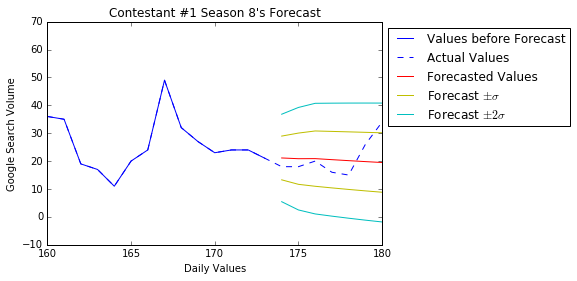

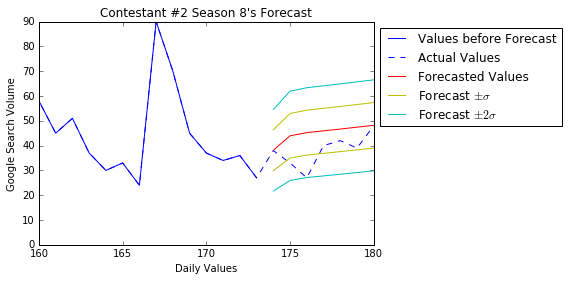

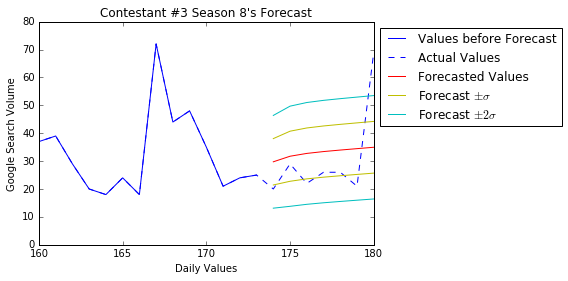

In [5]:
j = 0
for i in range(98, 101):
    actual = data.loc[indx[i, '0':'180']].values
    f.plotting_forecast(S8.loc[indx[i, :'173']].values, 
                      actual, 
                      Phis[j], 
                      Thetas[j], 
                      Mus[j], 
                      Sigmas[j], 
                      f = 7, 
                      title = 'Contestant #{} Season {}\'s Forecast'.format(j+1, 8), 
                      lim = True)
    j += 1

Below we run the plotting_forecast function on the Contestants of Season 9. We only have information of the pre-season since the first episode starts March 24, 2017. We have no idea what the actual values for the rest of the season are since we don't have that information. Since we have forecast values with an accuracy within one or two standard deviation for the last week of the season from Season 8, we can be sure to get a similar accuracy for Season 9.

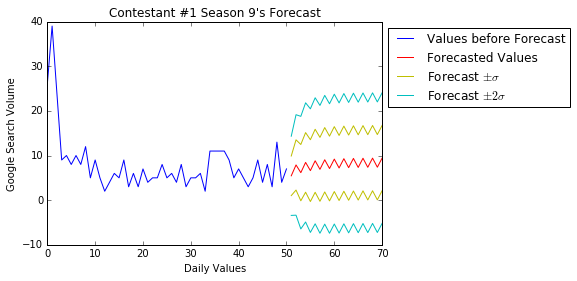

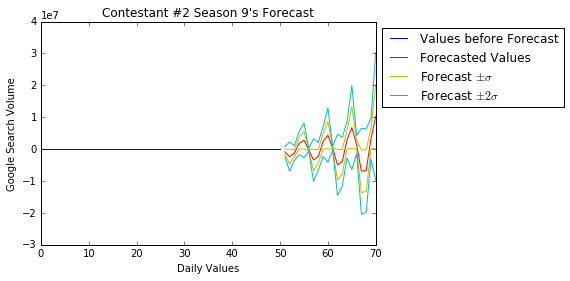

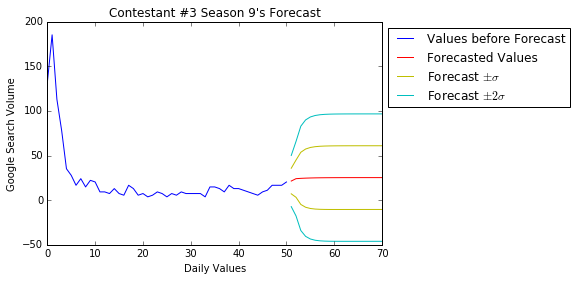

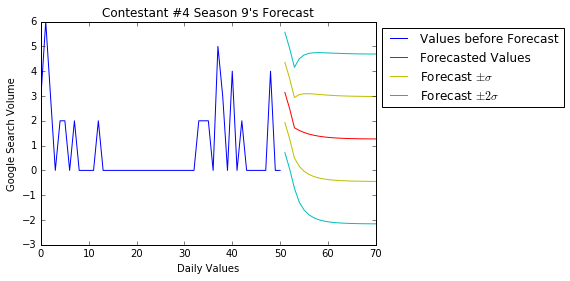

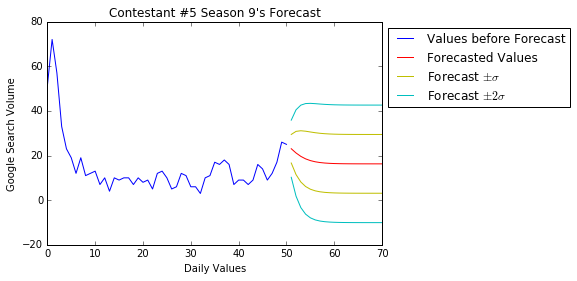

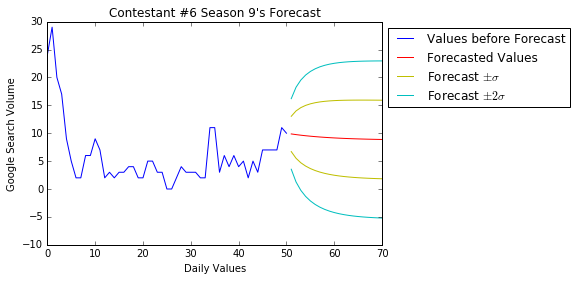

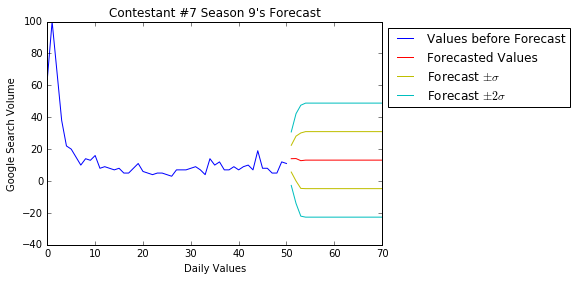

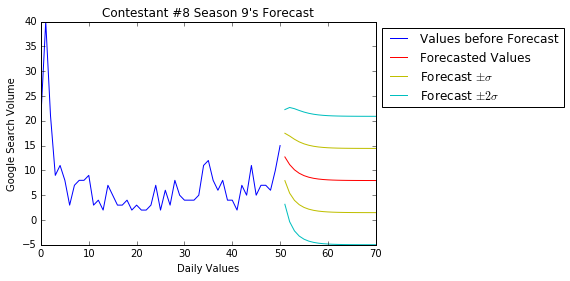

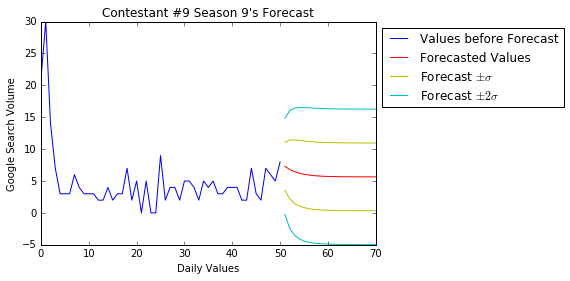

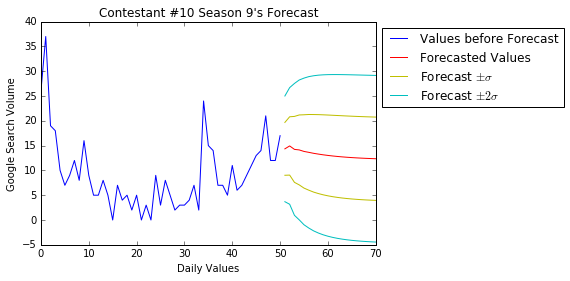

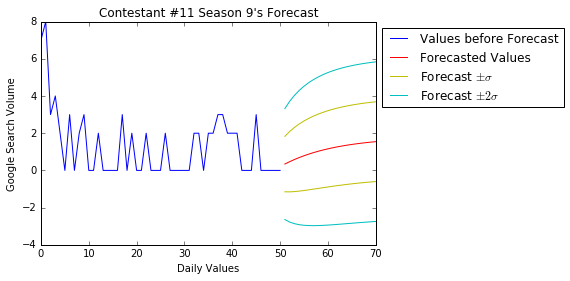

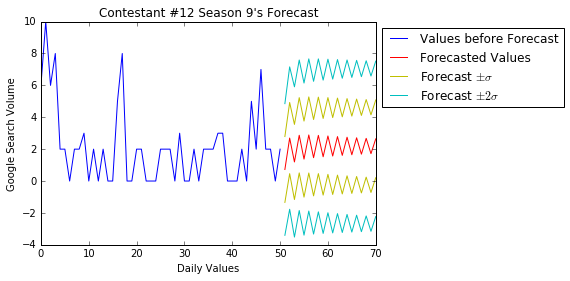

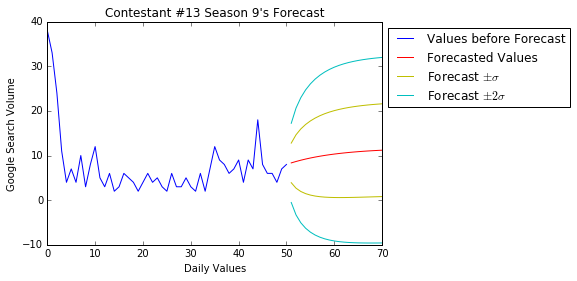

In [6]:
j = 0
for i in range(13):
    f.plotting_forecast(time_series = data_S9.loc[indx[i, '2017-02-02 00:00:00':'2017-03-24 00:00:00']].values, 
                      actual = None, 
                      phis = Phis1[j], 
                      thetas = Thetas1[j], 
                      mu = Mus1[j], 
                      sigma = Sigmas1[j], 
                      f = 20, 
                      title = 'Contestant #{} Season {}\'s Forecast'.format(j+1, 9), 
                      lim = False)
    j += 1

Looks like we know a bit of what the future holds for our contestants in Season 9. And it looks like the contestant to look out for in this season is contestant # 3. The graphs are useful for getting a visual glance at the contestants popularity and how that popularity will carry out. That will hopefully tell us who our Season 9 winner will be.